# 4 Modeling

## 4.1 Contents

- [4 Modeling](#modeling)
  - [4.1 Contents](#contents)
  - [4.2 Introduction](#introduction)
      - [4.2.1 Objective](#objective)
  - [4.3 Imports](#imports)
  - [4.4 Load the Data](#dataload)
  - [4.5 Metrics](#metrics)
  - [4.6 Models](#models)
     - [4.6.1 Logistic Regression](#logistic)
     - [4.6.2 Random Forest](#randomforest)
     - [4.6.3 Gradient Boosting](#gbm)
     - [4.6.4 Support Vector Machines](#svm)
   - [4.7 Hyperparameter Tuning](#hyperparameter)
       - [4.7.1 Hyperparameter Tuning with GridSearchCV](#gridsearchcv)
       - [4.7.2 Evaluating the Tuned Model](#tuned_eval)
       - [4.7.3 Implementing SMOTE for Oversampling the Minority Class](#SMOTE)
       - [4.7.4 Using Cost-Sensitive Learning](#cost_sensitive_learning)
       - [4.7.5 Adjusting the Classification Threshold](#classification_threshold)
       - [4.7.6 Visualizing Feature Importances](#feature_importances)
   - [4.8 Hyperparameter Tuning on Reduced Feature Set](#tuning_reduced_feature_set)
       - [4.8.1  Reduced Feature Set](#reduced_features)
       - [4.8.2 Implementing SMOTE](#smote_reduced)
       - [4.8.3 Parameter Tuning](#tuning_reduced)
       - [4.8.4 Train Model with Best Parameters](#train_model_best_parameters)
       - [4.8.5 Prediction and Threshold Adjustment](#threshold_adjustment)
       - [4.8.6 Visualizing Reduced Feature Importances](#reduced_feature_importances)
   - [4.9 Best Model](#bestmodel)
   - [4.10 Summary](#summary)
   - [4.11 Recommendations](#recommendations)
   - [4.12 Further Research](#research)

## 4.2 Introduction <a id="introduction"></a>

In this fourth stage, we'll take our preprocessed data from our preprocessing notebook (stage 3) and try different models to see which model yields the best performance, and tune our hyperparameters for maximizing these results. 

### 4.2.1 Objective <a id="objective"></a>

Our goal is to create and identify the optimal model that most accurately predicts fraudulent transactions in the Metaverse. We've previously conducted a thorough cleaning of our initial dataset gleaned Kaggle, explored and visualized our data, and then did some preprocessing and training for establishing a dataset ready for our models to train on. 

## 4.3 Imports <a id="imports"></a>

In [1]:
pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install featuretools


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as tick
import sklearn.model_selection

from operator import itemgetter
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier) 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

import featuretools as ft
from sklearn import neighbors, datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

class style:
   BOLD = '\033[1m'
   END = '\033[0m'

## 4.4 Load the Data <a id="dataload"></a>

In [55]:
X_train = pd.read_csv('/Users/joshuabe/Downloads/Capstone 3 - Metaverse Fraud Prediction/X_train.csv')
X_test = pd.read_csv('/Users/joshuabe/Downloads/Capstone 3 - Metaverse Fraud Prediction/X_test.csv')
y_train = pd.read_csv('/Users/joshuabe/Downloads/Capstone 3 - Metaverse Fraud Prediction/y_train.csv')
y_test = pd.read_csv('/Users/joshuabe/Downloads/Capstone 3 - Metaverse Fraud Prediction/y_test.csv')

In [56]:
# Confirm correct loading
print(X_train.head())
print(y_train.head())

     amount  login_frequency  session_duration  amount_per_login  \
0  0.294497         1.193056          0.304079         -0.575935   
1  2.358713         1.193056          1.978468         -0.200140   
2  0.277894        -1.339842         -1.074830          1.957815   
3 -1.853762         0.770907          0.870416         -0.961243   
4  0.008534         1.193056          1.412131         -0.627995   

   duration_per_login  location_region_Africa  location_region_Asia  \
0           -0.988592                     0.0                   0.0   
1            0.467238                     1.0                   0.0   
2            1.152334                     0.0                   0.0   
3           -0.121517                     0.0                   0.0   
4           -0.025175                     0.0                   0.0   

   location_region_Europe  location_region_North America  \
0                     1.0                            0.0   
1                     0.0                   

## 4.5 Metrics <a id="metrics"></a>

Metrics Considerations: 

- If your system can handle a higher number of false positives (which means more transactions flagged for manual review), focusing on Recall might be more beneficial to ensure no fraudulent transactions slip through.
- If your goal is to maintain a balance between catching frauds and not overwhelming the manual review team or system with false alerts, ROC-AUC might be more appropriate. It helps you understand at which threshold the model performs best overall, considering both false positives and false negatives.

Our metrics will be: 
- **Accuracy**: Measures the overall correctness of the model but can be misleading if the data is imbalanced.
- **Precision and Recall**: Especially important in fraud detection to minimize false positives (precision) and false negatives (recall). We might prioritize recall to capture as many fraudulent transactions as possible, even if it means enduring more false positives.
- **F1 Score**: Harmonic mean of precision and recall. It's a balanced metric that is useful when you need a trade-off between precision and recall.
- **ROC-AUC**: Measures the ability of your model to discriminate between classes. A higher AUC value indicates a better performing model.
- **Confusion Matrix**: Provides a summary of prediction results on a classification problem. Great for visualizing the performance of an algorithm.
     

These metrics will provide a comprehensive view of the model's performance, considering both the accuracy and the robustness in handling class imbalance, which is typical in fraud detection scenarios.

## 4.6 Models <a id="models"></a>

We'll try four different models and evaluate the performance of each to find the best one. We'll also perform cross-validation to evaluate how well a model is likely to perform on unseen data by using different subsets of the training data for both training and validation. 

### 4.6.1 Logistic Regression <a id="logistic"></a>

Logistic regression is ideal for our initial attempt due to its simplicity and efficiency. We'll then compare the performance of simpler vs more complex models incrementally. 

In [39]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Fit the model on the training data
log_reg.fit(X_train, y_train.values.ravel())

# Predict on the test data
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_conf_matrix = confusion_matrix(y_test, y_pred_log_reg)
log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
log_recall = recall_score(y_test, y_pred_log_reg)

print("Logistic Regression Accuracy:", log_reg_accuracy)
print("Recall:", log_recall)
print("Confusion Matrix:\n", log_reg_conf_matrix)
print("ROC-AUC:", log_reg_roc_auc)

Logistic Regression Accuracy: 0.9202290076335878
Recall: 0.0
Confusion Matrix:
 [[14466     3]
 [ 1251     0]]
ROC-AUC: 0.8687001880975005


The logistic regression model achieved high accuracy of roughly 92%, with a good ROC-AUC value, but the confusion matrix indicates a failure to identify any fraudulent transactions (0 true positives). 

### 4.6.2 Random Forest <a id="randomforest"></a>

In [57]:
# Initialize the Random Forest model
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the model on the training data
random_forest.fit(X_train, y_train.values.ravel())

# Predict on the test data
y_pred_rf = random_forest.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
rf_recall = recall_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", rf_accuracy)
print("Recall:", rf_recall)
print("Confusion Matrix:\n", rf_conf_matrix)
print("ROC-AUC:", rf_roc_auc)

Random Forest Accuracy: 0.9179389312977099
Recall: 0.008792965627498001
Confusion Matrix:
 [[14419    50]
 [ 1240    11]]
ROC-AUC: 0.8653108475967171


The Random Forest model achieved high accuracy of close to 92%, with another solid ROC-AUC value, and is most effective thus far at capturing fraudulent cases (11 true positives). 

### 4.6.3 Gradient Boosting <a id="gbm"></a>

In [41]:
# Initialize the Gradient Boosting model
gradient_boosting = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Fit the model on the training data
gradient_boosting.fit(X_train, y_train.values.ravel())

# Predict on the test data
y_pred_gb = gradient_boosting.predict(X_test)

# Evaluate the model
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_conf_matrix = confusion_matrix(y_test, y_pred_gb)
gb_roc_auc = roc_auc_score(y_test, gradient_boosting.predict_proba(X_test)[:, 1])
gb_recall = recall_score(y_test, y_pred_gb)

print("Gradient Boosting Accuracy:", gb_accuracy)
print("Recall:", gb_recall)
print("Confusion Matrix:\n", gb_conf_matrix)
print("ROC-AUC:", gb_roc_auc)

Gradient Boosting Accuracy: 0.9204198473282442
Recall: 0.0015987210231814548
Confusion Matrix:
 [[14467     2]
 [ 1249     2]]
ROC-AUC: 0.8689436038424772


Gradient Boosting has high accuracy and ROC-AUC value as well, but only identified 2 fraudulent cases (2 true positives). 

### 4.6.4 Support Vector Machines <a id="svm"></a>

In [42]:
# Initialize the Support Vector Machine model
svm = SVC(kernel='linear', probability=True, random_state=42)

# Fit the model on the training data
svm.fit(X_train, y_train.values.ravel())

# Predict on the test data
y_pred_svm = svm.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)
svm_roc_auc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
svm_recall = recall_score(y_test, y_pred_svm)

print("SVM Accuracy:", svm_accuracy)
print("Recall:", svm_recall)
print("Confusion Matrix:\n", svm_conf_matrix)
print("ROC-AUC:", svm_roc_auc)

SVM Accuracy: 0.9204198473282442
Recall: 0.0
Confusion Matrix:
 [[14469     0]
 [ 1251     0]]
ROC-AUC: 0.8668866137306479


Similar accuracy and ROC-AUC values as the other four models, and it failed to identify any fraudulent cases (0 true positives), just like Logistic Regression. 

**Analysis:** 

- **Overall Accuracy**: All models show similar accuracy scores around 0.92. This suggests that they are equally capable of correctly classifying the non-fraudulent transactions.
- **ROC-AUC**: All models also have similar ROC-AUC values, which measure the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The highest is seen in Gradient Boosting at 0.8689, but the difference is marginal.
- **Sensitivity and Specificity**: Random Forest and Gradient Boosting models managed to correctly identify some fraudulent transactions (true positives), unlike Logistic Regression and SVM, which failed to identify any fraudulent cases (0 true positives). This might indicate that ensemble methods are capturing some patterns missed by Logistic Regression and SVM.

**Choosing the Best Model**: 

- **Random Forest seems much more effective in capturing fraudulent transactions** (11 true positives) compared to Gradient Boosting (2 true positives) and Logistic Regression or SVM (0 true positives).
- While Random Forest shows a higher true positive rate, it also has a much higher number of false positives (50 false positives) compared to Gradient Boosting (2 false positives) and SVM or Logistic Regression (0 false positives). However, capturing more true positives in a fraud detection scenario might be more valuable than avoiding a relatively small number of false positives.

**Random Forest stands out as the best option** among the four given its balanced performance in accuracy, its ability to capture more true positives (an essential factor in fraud detection), and its competitive ROC-AUC score. It strikes a reasonable balance between sensitivity and specificity, making it particularly useful for practical applications in fraud detection where missing actual fraud cases (false negatives) can be very costly.

## 4.7 Hyperparameter Tuning <a id="hyperparameter"></a>

We'll now proceed with hyperparameter tuning of our Random Forest model. 

### 4.7.1 Hyperparameter Tuning with GridSearchCV <a id="gridsearchcv"></a>

First, let's fine-tune the Random Forest model using GridSearchCV to explore a range of parameter values. 

**We'll use Recall as our scoring metric** for grid search, since it focuses on the model's ability to correctly identify all positive instances (true positives). **For fraud detection, a high recall means catching more actual frauds**, even if it leads to more false positives (non-fraud transactions incorrectly labeled as fraud).

This is ideal because in most fraud detection instances, the cost of missing a fraud (false negative) is much higher than the cost of flagging a legitimate transaction as fraudulent (false positive).

In [58]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, cv=3, scoring='recall', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.values.ravel())

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   5.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   5.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   5.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_de

### 4.7.2 Evaluating the Tuned Model <a id="tuned_eval"></a>

Now that we've identified the best parameters, we'll evaluate the tuned model on the test data. 

**Refresher of Key Metrics:** 

- **Accuracy**: Total percentage of correctly predicted instances (both true positives and true negatives).
- **Confusion Matrix**: Provides a visual understanding of the model performance beyond just the metrics, showing the actual numbers for true positives, true negatives, false positives, and false negatives.
- **ROC-AUC**: How well the model distinguishes between classes; a higher AUC indicates a better performing model across all classification thresholds.
- **Recall (Sensitivity)**: Proportion of actual positives (fraud cases) that were correctly identified, crucial for fraud detection.
- **Precision**: Proportion of positive identifications that were actually correct, indicating the quality of positive predictions.
- **F1 Score**: Harmonic mean of recall and precision. 

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

# Retrieve the best model from grid search
best_rf = grid_search.best_estimator_

# Predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the model
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_conf_matrix = confusion_matrix(y_test, y_pred_best_rf)
best_rf_roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
best_rf_recall = recall_score(y_test, y_pred_best_rf)
best_rf_precision = precision_score(y_test, y_pred_best_rf)
best_rf_f1_score = f1_score(y_test, y_pred_best_rf)

# Generate the confusion matrix and classification report
print("Confusion Matrix:\n", (confusion_matrix(y_test, y_pred_best_rf)))
print(classification_report(y_test, y_pred_best_rf))

# Print the results
print("Best Random Forest Accuracy:", best_rf_accuracy)
print("Confusion Matrix:\n", best_rf_conf_matrix)
print("ROC-AUC:", best_rf_roc_auc)
print("Recall:", best_rf_recall)
print("Precision:", best_rf_precision)
print("F1 Score:", best_rf_f1_score)

Confusion Matrix:
 [[14424    45]
 [ 1241    10]]
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     14469
        True       0.18      0.01      0.02      1251

    accuracy                           0.92     15720
   macro avg       0.55      0.50      0.49     15720
weighted avg       0.86      0.92      0.88     15720

Best Random Forest Accuracy: 0.9181933842239186
Confusion Matrix:
 [[14424    45]
 [ 1241    10]]
ROC-AUC: 0.8663399503632977
Recall: 0.007993605115907274
Precision: 0.18181818181818182
F1 Score: 0.015313935681470138


The tuned model results in a high accuracy of nearly 92% with a strong ROC-AUC value of 0.86. Crucially, the Confusion Matrix also shows 45 true positives and just 10 false positives. This indicates the tuned model is capable of identifying fraudulent transactions. 

However, **the extremely low recall indicates that the model fails to identify the majority of fraudulent transactions, capturing only about 0.8% of fraud. This is a significant concern as it implies the model is not effective at detecting fraud.** In addition, Precision assesses the accuracy of the positive predictions. The Precision of 18% means that out of all transactions predicted as fraud, only about 18% actually were fraudulent. This suggests that when the model predicts fraud, it is relatively unreliable. 

To create a model more effective at fraud identification, I'll adjust the classification threshold, use cost-sensitive learning, and implement SMOTE technique for oversampling the minority class. 

### 4.7.3 Implementing SMOTE for Oversampling the Minority Class <a id="SMOTE"></a>

SMOTE (Synthetic Minority Over-sampling Technique) is a technique that generates synthetic samples from the minority class. This approach helps balance the class distribution, which can improve the performance of classification algorithms.

In [60]:
pip install --upgrade scikit-learn imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [61]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Now X_train_smote and y_train_smote are the oversampled data

### 4.7.4 Using Cost-Sensitive Learning <a id="cost_sensitive_learning"></a>

Cost-sensitive learning adjusts the model to give more importance to certain classes during the training phase. For many classifiers, you can adjust the class_weight parameter to make the model more sensitive to the minority class.

In [62]:
# TRAIN THE MODEL: 

# Initialize the classifier with class_weight set to 'balanced'
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model on the SMOTE-augmented training data
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', random_state=42)

### 4.7.5 Adjusting the Classification Threshold <a id="classification_threshold"></a>

After training the model, instead of using the default threshold of 0.5 to classify observations as positive or negative, you adjust the threshold to improve recall, perhaps at the expense of precision or vice versa, depending on the business cost of false negatives versus false positives.

In [63]:
import numpy as np
from sklearn.metrics import roc_curve

# Predict probabilities for the test data
probabilities = rf.predict_proba(X_test)[:, 1]

# Determine the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Find the optimal threshold, this is an example to maximize tpr (recall) and minimize fpr
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use this threshold to adjust predictions
y_pred_adjusted = (probabilities >= optimal_threshold).astype(int)

# Evaluate performance
from sklearn.metrics import confusion_matrix, recall_score, precision_score
print("Adjusted Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("Adjusted Recall:", recall_score(y_test, y_pred_adjusted))
print("Adjusted Precision:", precision_score(y_test, y_pred_adjusted))
print("Adjusted F1 Score:", f1_score(y_test, y_pred_adjusted))

Adjusted Confusion Matrix:
 [[10605  3864]
 [    0  1251]]
Adjusted Recall: 1.0
Adjusted Precision: 0.24457478005865102
Adjusted F1 Score: 0.3930254476908577


### 4.7.6  Visualizing Feature Importances <a id="feature_importances"></a>

Now, let's create a bar graph to visualize the feature importances of the tuned Random Forest model. This will provide insights into which features are most influential in predicting the output.

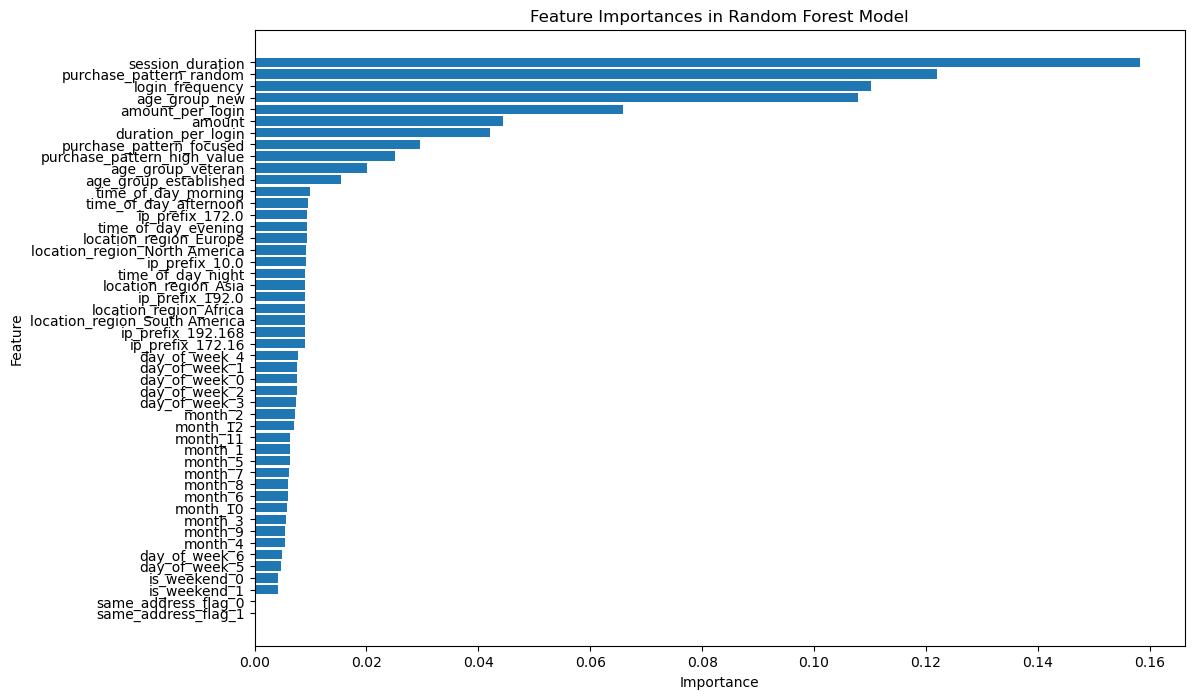

In [64]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importances in Random Forest Model')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # This inverts the y-axis so the highest values are at the top
plt.show()

We've used the full set of 48 features for this model, but let's try reducing the feature set to only the top 10 most important features to see if performance improves. 

## 4.8 Hyperparameter Tuning on Reduced Feature Set <a id="tuning_reduced_feature_set"></a>

### 4.8.1  Reduced Feature Set <a id="reduced_features"></a>

In [66]:
# Get the indices of the top 10 features
indices = np.argsort(importances)[::-1][:10]

# Select the top 10 most important feature names
top_features = X_train.columns[indices]

# Reduce the feature set
X_train_reduced_smote = X_train[top_features]
X_test_reduced_smote = X_test[top_features]

### 4.8.2  Apply SMOTE <a id="smote_reduced"></a>

In [67]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_reduced_smote, y_train_reduced_smote = smote.fit_resample(X_train_reduced, y_train)

### 4.8.3  Parameter Tuning <a id="tuning_reduced"></a>

In [71]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                           param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring='recall')

# Fit GridSearchCV to the reduced feature set, ensuring y_train is properly formatted as a 1D array
grid_search.fit(X_train_reduced_smote, y_train_reduced_smote.values.ravel())

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best score: 0.9985078586575271


### 4.8.4 Train Model with Best Parameters <a id="train_model_best_parameters"></a>

In [72]:
# Train the model with cost-sensitive learning using best parameters
model_reduced = RandomForestClassifier(**grid_search.best_params_, random_state=42)
model_reduced.fit(X_train_reduced_smote, y_train_reduced_smote)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, random_state=42)

### 4.8.5 Prediction and Threshold Adjustment <a id="threshold_adjustment"></a>

In [78]:
# Predict probabilities and adjust the threshold
probabilities = model_reduced.predict_proba(X_test_reduced)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probabilities)
optimal_idx = np.argmax(precision * recall)  # Find the optimal trade-off point
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to make final predictions
y_pred_reduced_optimal = (probabilities >= optimal_threshold).astype(int)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_reduced_optimal))
print("Classification Report:\n", classification_report(y_test, y_pred_reduced_optimal))

Confusion Matrix:
 [[10621  3848]
 [    2  1249]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.73      0.85     14469
        True       0.25      1.00      0.39      1251

    accuracy                           0.76     15720
   macro avg       0.62      0.87      0.62     15720
weighted avg       0.94      0.76      0.81     15720



The metrics are virtually identical to the full 48 feature set model; 25% precision, ~100% recall, and a 39% F1 Score. 

### 4.8.6  Visualizing Reduced Feature Importances <a id="reduced_feature_importances"></a>

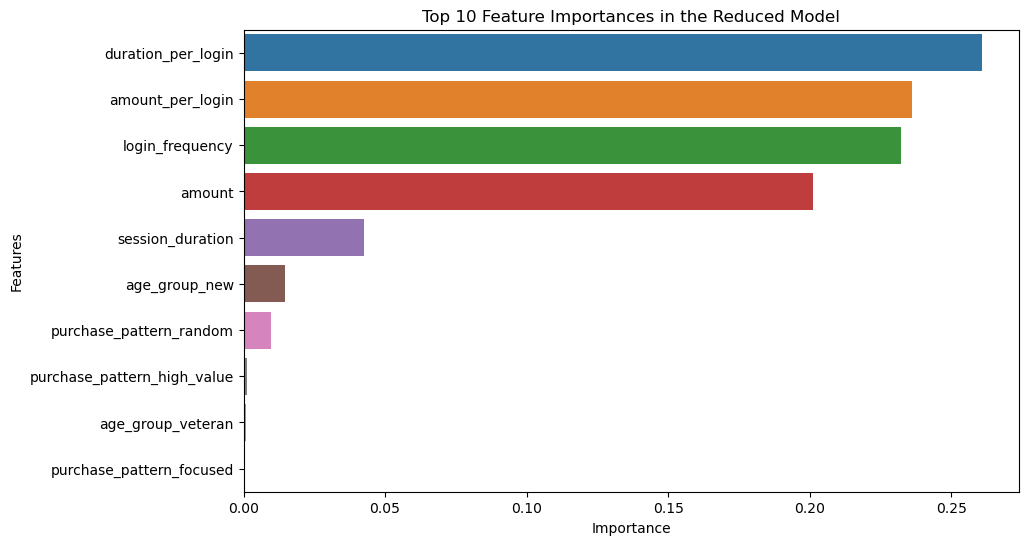

In [75]:
# Visualize Feature Importances

# Recalculate importances for the reduced model
reduced_importances = model_reduced.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_df = pd.DataFrame({'Features': top_features, 'Importance': reduced_importances})

# Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=features_df, orient='h')
plt.title('Top 10 Feature Importances in the Reduced Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

The feature importance analysis revealed that **the five most important features for the model, by a wide margin, are: duration_per_login, amount_per_login, login_frequency, amount, and session_duration**. 


This yields a few insights: 
- **Duration Per Login**: this is of prime importance since there tends to be a slightly higher duration per login for fraudulent transactions, indicating fraudsters take their time for enacting their criminal activities. 
- **Session Duration and Login Frequency**: It's unsurprising that both are among the top five most important features, since we discovered during EDA that both display moderate negative correlations with fraud. This implies that lower login frequencies as well as lower total session durations are associated with fraud. So fraudsters login less frequently, and thus their cumulative session durations are lower than average, but they have longer session times per each individual login (hence the importance of duration per login). 
- **Amount Per Login**: We discovered during our EDA section that Amount Per Login shows a moderate positive correlation with fraud, and we now see it as among the top two most important features. This indicates that larger but less frequent transactions are associated with fraudulent behavior. 

## 4.9 Best Model <a id="bestmodel"></a>

After evaluating various models, including Logistic Regression, Random Forest, Gradient Boosting, Support Vector Machines, the model that best balances precision and recall while minimizing false negatives is the **Random Forest classifier with class weighting set to 'balanced' (10 feature set)**. Minimizing false negatives is essential in fraud prediction to ensure no fraudulent transactions slip through, and this model did the best job of this. 

While there were 2 false negatives that slipped through on the reduced feature set model compared to 0 false negatives for the full 48 features model, the feature-reduced model is much more interpretable than the full-featured model while having almost exactly identical metrics, so we'll opt for the reduced model. This model integrates the strengths of RandomForest and SVC with Logistic Regression as the final estimator, providing a robust solution by capturing just about all fraud cases with a reasonable rate of false positives. 

- **Model**: `RandomForestClassifier(class_weight='balanced', random_state=42)`
- **Precision**: 25%
- **Recall**: 100% (1.0)
- **F1-Score**: 39% 
- **Confusion Matrix**:
  - True Negatives: 10,621
  - False Positives: 3,848
  - False Negatives: 2
  - True Positives: 1249

This model was specifically effective due to its ability to adapt to the class imbalance inherent in the dataset, significantly improving the recall to ensure almost no fraudulent transaction is missed, which is crucial for fraud prevention systems. 

*However, the obvious limitation to this model is its relatively low precision, which indicates that while the model is highly effective in identifying fraudulent transactions (high recall), it also incorrectly classifies a significant number of legitimate transactions as fraudulent (high false positives). This can lead to increased operational costs and potential customer dissatisfaction due to potentially unnecessary fraud investigations.*

In [82]:
# Save the Best Model: 

import pickle

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_reduced_smote, y_train_reduced_smote) 

# Save the model to a binary file
with open('best_random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

## 4.10 Summary <a id="summary"></a>

This project set out to address the challenge of fraud detection within a highly imbalanced dataset typical of financial transaction data. Throughout the project, various machine learning techniques were employed and evaluated based on their ability to identify fraudulent transactions accurately:

- **Data Preprocessing**: Included handling missing values, encoding categorical variables, and scaling numeric features.
- **Model Evaluation**: Involved adjusting classification thresholds, applying SMOTE for dealing with class imbalance, and experimenting with both single models and advanced ensemble techniques.
- **Performance Metrics**: Focus was given to precision, recall, and the F1-score to ensure a balanced evaluation of model performance.

Despite challenges, particularly in achieving high recall without sacrificing precision, the project demonstrated comprehensive data science capabilities in tackling a complex real-world problem.

## 4.11 Recommendations <a id="recommendations"></a>

Based on the modeling results and overall analysis, here are three concrete recommendations: 

1. **Implement Real-Time Monitoring**: Integrate the fraud prediction model into your transaction processing system to enable real-time fraud detection, allowing for immediate action on suspicious transactions, thereby reducing potential losses from delayed fraud identification.

2. **Continuous Model Updates**: Regularly update the fraud prediction model with new transaction data to adapt to evolving fraud patterns and techniques, ensuring that the model remains effective over time and reduces the incidence of both false positives and missed fraud cases.

3. **Enhanced Customer Verification Measures**: Based on insights from the model, especially from features heavily influencing fraud predictions, implement stronger verification processes for transactions identified as high-risk, such as two-factor authentication or manual reviews, to further safeguard against fraud.

## 4.12 Further Research <a id="research"></a>

For future work on this project or similar projects, the following recommendations are made to enhance model performance and operational effectiveness:

1. **Feature Engineering**: Explore additional features or interactions that may improve the model's ability to discriminate between classes, which would ideally increase our currently low precision to allow for a greater balance between this and recall. 
2. **Alternative Algorithms**: Investigate other algorithms known for handling imbalanced data well, such as XGBoost or LightGBM, which might offer improvements in precision.
3. **Incremental Learning**: Consider models that support incremental learning, allowing the system to evolve as new data becomes available.
4. **Deployment Strategy**: Develop a deployment strategy that includes real-time analysis and the ability to retrain the model periodically with new transaction data.
5. **Cost-Benefit Analysis**: Perform a detailed cost-benefit analysis to better understand the implications of false positives versus false negatives, potentially adjusting the class weights or threshold accordingly.

By following these recommendations, the fraud detection system can be further refined and better integrated into operational frameworks to reduce both the incidence and impact of financial fraud.